### analyze coverage at homopolymer loci
In the OMS cohort, we found a lot of samples with a frameshift insertion in the start coding of IGLON5. However that insertion locate in the begin homopolymer of C. Illumina usually may have errors in sequencing the homopolymer regions. So here we want to verify if the insertion in IGLON5 is due to the sequencing error. We looked at all the homopolymer loci in the genome and check the read coverage at those loci.

In [230]:
'''
1. get coverage for coding homopolymer
    1.1 include all reads.
    bsub -o log.txt -q medium "samtools mpileup -A \
              -l f01_GRCh37_homopolyC_in_coding_begin.bed -f \ 
              ../human_g1k_v37.fasta ../OMS_009_01.bam > all_begin.txt"
    1.2 include correctly mapping, concordant reads
2. get coverage for genome homopolymer
    2.1 include all reads.
    bsub -o log.txt -q medium "samtools mpileup -A \
              -l f02_GRCh37_homopolyC_whole_genome_begin.bed -f \ 
              ../human_g1k_v37.fasta ../OMS_009_01.bam > "
    2.2 include correctly mapped reads.
    .
    
'''
import pandas as pd
import re
from matplotlib import pyplot as plt
plt.style.use('ggplot')
path = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/BCH/pileup'

#============ 1. coding coverage
def get_begin_pos_of_homopolyC(in_bed,begin_bed):
    df = pd.read_csv(in_bed,sep='\t',header=None)
    df[2] = df[1]
    df[1] = df[2] - 1
    df.to_csv(begin_bed, sep='\t', index=False, header=None)
# 1. extract begin loci of the homopolymer
code_region_bed_fn = path + '/f01_GRCh37_homopolyC_in_coding.bed'
code_begin_bed_fn = path + '/f01_GRCh37_homopolyC_in_coding_begin.bed'
get_begin_pos_of_homopolyC(code_region_bed_fn, code_begin_bed_fn)
df = pd.read_csv(code_region_bed_fn,sep='\t',header=None)
print('there are',df.shape[0],'homopolymer C regions in coding regions')
genome_region_bed_fn = path + '/f02_GRCh37_homopolyC_whole_genome.bed'
genome_begin_bed_fn = path + '/f02_GRCh37_homopolyC_whole_genome_begin.bed'
get_begin_pos_of_homopolyC(genome_region_bed_fn, genome_begin_bed_fn)
df = pd.read_csv(genome_region_bed_fn, sep='\t', header=None)
print('there are',df.shape[0],'homopolymer C regions in the whole genome')

there are 135 homopolymer C regions in coding regions
there are 15206 homopolymer C regions in the whole genome


In [213]:
# 2. extract the coverage using samtools mpileup
code_cov_fn = path + '/f01_GRCh37_homopolyC_coverage_in_coding.txt'
code_cov_all_fn = path + '/f01_GRCh37_homopolyC_coverage_all_read_in_coding.txt'
'''
bsub -o log.txt -q medium "samtools mpileup -A \
              -l f01_GRCh37_homopolyC_in_coding_begin.bed -f \ 
              ../human_g1k_v37.fasta ../OMS_009_01.bam > all_begin.txt"
'''
genome_cov_fn = path + '/f02_GRCh37_homopolyC_coverage_in_genome.txt'
genome_cov_all_fn = path + '/f02_GRCh37_homopolyC_coverage_all_read_in_genome.txt'

In [214]:
# 3. analyze the coverage
def count_read(string):
    '''
    input is 5th column in mpileup file, and the 
    '''
    string = string[4].lower()
    insert = re.findall('\+\d+',string)
    one_insert = insert.count('+1')
    other_insert = len(insert) - one_insert
    return pd.Series([one_insert,other_insert])

In [215]:
vari_fn = path + '/variants.vcf.gz'
vari_df = pd.read_csv(vari_fn,sep='\t',comment='#',compression='gzip',header=None)
vari_df['id'] = vari_df[0].astype('str') + ':' + vari_df[1].astype('str') + \
            vari_df[3].astype('str') + ':' + vari_df[4].astype('str')

/hpc/grid/wip_drm_targetsciences/users/shangzhong/.conda/envs/hail/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [216]:
def get_read_portion(pile_fn, vari_df):
    '''
    get portion of reads that support the insertion
    '''
    loc_df = pd.read_csv(pile_fn, sep='\t',header=None)
    loc_df[['one_ins','more_ins']] = loc_df.apply(lambda x:count_read(x),axis=1)
    loc_df['cov'] = loc_df[3] + loc_df['one_ins'] + loc_df['more_ins']
    loc_df['one_perc'] = loc_df['one_ins'] / loc_df['cov'] 
    loc_df['id'] = loc_df[0].astype('str') +':' + loc_df[1].astype('str') + \
                    loc_df[2].astype('str') + ':' + loc_df[2].astype('str') + 'C'
    loc_ids = loc_df['id'].tolist()
    call_vari_id = vari_df.query('id in @loc_ids')['id'].tolist()
    loc_df['called'] = loc_df['id'].map(lambda x:'Y' if x in call_vari_id else 'N')
    return loc_df

In [232]:
code_cov_df = get_read_portion(code_cov_fn, vari_df)
print('there are',code_cov_df[3].sum(),'reference reads in coding reagions')
print(code_cov_df['one_ins'].sum(),'one insertion reads in coding reagions')
print(code_cov_df['more_ins'].sum(),'more insertion reads in coding reagions')

there are 1717 reference reads in coding reagions
253 one insertion reads in coding reagions
83 more insertion reads in coding reagions


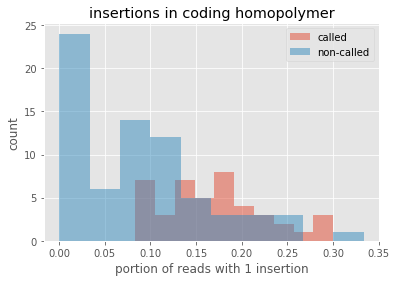

In [223]:
plt.hist(code_cov_df.query('called == "Y"')['one_perc'].tolist(),alpha=0.5,label='called')
plt.hist(code_cov_df.query('called == "N"')['one_perc'].tolist(),alpha=0.5,label='non-called')
plt.xlabel('portion of reads with 1 insertion')
plt.ylabel('count')
plt.title('insertions in coding homopolymer')
plt.legend()

In [235]:
genome_cov_df = get_read_portion(genome_cov_fn, vari_df)
print('there are',genome_cov_df[3].sum(),'reference reads in whole genome reagions')
print(genome_cov_df['one_ins'].sum(),'one insertion reads in whole genome reagions')
print(genome_cov_df['more_ins'].sum(),'more insertion reads in whole genome reagions')

there are 241312 reference reads in whole genome reagions
24667 one insertion reads in whole genome reagions
8049 more insertion reads in whole genome reagions


/hpc/grid/wip_drm_targetsciences/users/shangzhong/.conda/envs/hail/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/hpc/grid/wip_drm_targetsciences/users/shangzhong/.conda/envs/hail/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


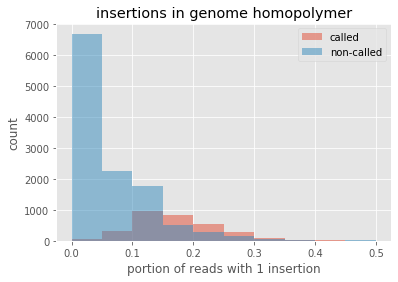

In [236]:
plt.hist(genome_cov_df.query('called == "Y"')['one_perc'].tolist(),alpha=0.5,label='called')
plt.hist(genome_cov_df.query('called == "N"')['one_perc'].tolist(),alpha=0.5,label='non-called')
plt.xlabel('portion of reads with 1 insertion')
plt.ylabel('count')
plt.title('insertions in genome homopolymer')
plt.legend()